# Perkenalan

Perkenalkan nama saya Wildan Abdurrasyid seorang Mahasiswa sem 3 Institut Teknologi Tangerang Selatan.

pada proyek ini saya akan membuat Model TS (Time Series) sederhana dari dataset yang telah saya dapatkan.

link source dataset: https://www.kaggle.com/datasets/hmavrodiev/london-bike-sharing-dataset/

In [202]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM, Dropout, Bidirectional
import matplotlib.pyplot as plt
import tensorflow as tf

In [203]:
df = pd.read_csv('london_merged.csv')
df = df[['timestamp', 'cnt']]
df

,timestamp,cnt
0,2015-01-04 00:00:00,182
1,2015-01-04 01:00:00,138
2,2015-01-04 02:00:00,134
3,2015-01-04 03:00:00,72
4,2015-01-04 04:00:00,47
...,...,...
17409,2017-01-03 19:00:00,1042
17410,2017-01-03 20:00:00,541
17411,2017-01-03 21:00:00,337
17412,2017-01-03 22:00:00,224


In [204]:
df['timestamp'] = pd.to_datetime(df['timestamp'].astype(str))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  17414 non-null  datetime64[ns]
 1   cnt        17414 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 272.2 KB


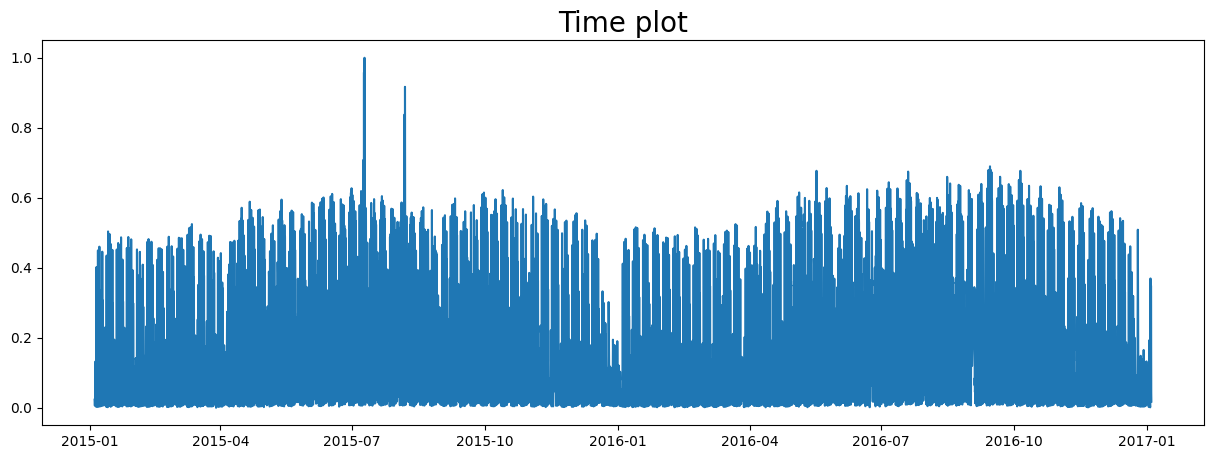

In [205]:
scaler = MinMaxScaler()
df['cnt'] = scaler.fit_transform(df['cnt'].values.reshape(-1, 1)).flatten()
X = df['timestamp'].values
Y  = df['cnt'].values
plt.figure(figsize=(15,5))
plt.plot(X, Y)
plt.title('Time plot', fontsize=20);

In [206]:
# Split data into training and validation sets
train_size = int(len(df) * 0.8)
train_data, test_data = df[:train_size], df[train_size:]
train_data, test_data

(                timestamp       cnt
 0     2015-01-04 00:00:00  0.023155
 1     2015-01-04 01:00:00  0.017557
 2     2015-01-04 02:00:00  0.017048
 3     2015-01-04 03:00:00  0.009160
 4     2015-01-04 04:00:00  0.005980
 ...                   ...       ...
 13926 2016-08-09 22:00:00  0.109415
 13927 2016-08-09 23:00:00  0.063232
 13928 2016-08-10 00:00:00  0.038422
 13929 2016-08-10 01:00:00  0.016794
 13930 2016-08-10 02:00:00  0.007252
 
 [13931 rows x 2 columns],
                 timestamp       cnt
 13931 2016-08-10 03:00:00  0.004326
 13932 2016-08-10 04:00:00  0.006489
 13933 2016-08-10 05:00:00  0.018321
 13934 2016-08-10 06:00:00  0.106743
 13935 2016-08-10 07:00:00  0.300509
 ...                   ...       ...
 17409 2017-01-03 19:00:00  0.132570
 17410 2017-01-03 20:00:00  0.068830
 17411 2017-01-03 21:00:00  0.042875
 17412 2017-01-03 22:00:00  0.028499
 17413 2017-01-03 23:00:00  0.017684
 
 [3483 rows x 2 columns])

## Define windowed dataset function

In [207]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds.repeat()

train_set = windowed_dataset(train_data['cnt'].values, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(test_data['cnt'].values, window_size=60, batch_size=100, shuffle_buffer=1000)

In [208]:
steps_per_epoch_train = len(train_data) // 100
steps_per_epoch_val = len(test_data) // 100

## Build the model

In [209]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, input_shape=[None, 1])),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(120, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])

## Fungsi Callbacks

In [210]:
threshold_mae = (df['cnt'].max() - df['cnt'].min()) * 10/100
class my_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae') < threshold_mae and logs.get('val_mae') < threshold_mae):
            print(" \n MAE dari model < 10% skala data")
            self.model.stop_training = True

callbacks = my_callback()

## Compile the model

In [211]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-01, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics=["mae"])

## Train the model with validation data

In [212]:
history = model.fit(train_set, epochs=50, steps_per_epoch=steps_per_epoch_train,
                    validation_data=val_set, validation_steps=steps_per_epoch_val,
                    callbacks=[callbacks])

Epoch 1/50
139/139 [==============================] - 114s 753ms/step - loss: 0.0089 - mae: 0.1034 - val_loss: 0.0110 - val_mae: 0.1259
Epoch 2/50
139/139 [==============================] - 105s 754ms/step - loss: 0.0089 - mae: 0.1032 - val_loss: 0.0098 - val_mae: 0.1134
Epoch 3/50
139/139 [==============================] - 105s 754ms/step - loss: 0.0088 - mae: 0.1026 - val_loss: 0.0098 - val_mae: 0.1138
Epoch 4/50
139/139 [==============================] - ETA: 0s - loss: 0.0076 - mae: 0.0934 
 MAE dari model < 10% skala data
139/139 [==============================] - 101s 729ms/step - loss: 0.0076 - mae: 0.0934 - val_loss: 0.0070 - val_mae: 0.0883


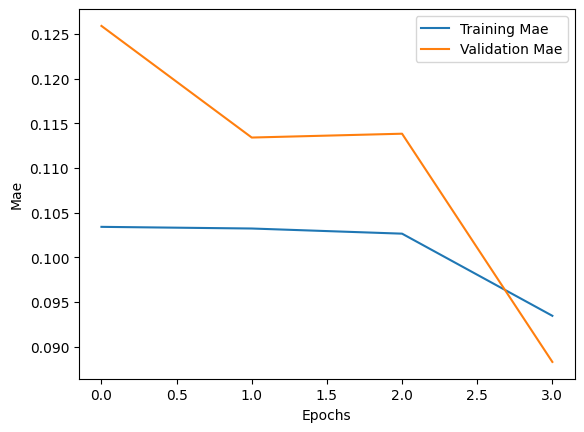

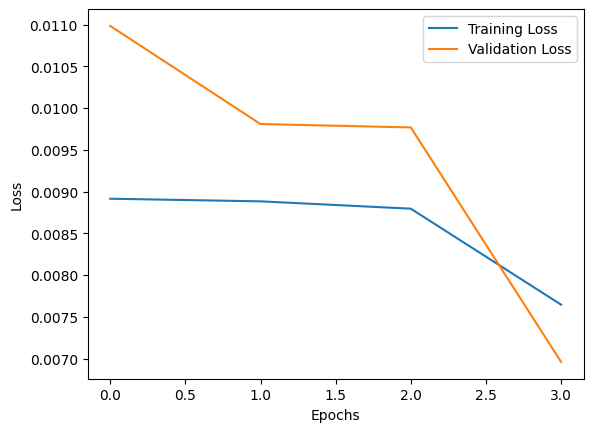

In [213]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'], label='Training Mae')
plt.plot(history.history['val_mae'], label='Validation Mae')
plt.xlabel('Epochs')
plt.ylabel('Mae')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()